## Cellpose trained to learn saturated double circles

This example makes a simple simulation to test whether cellpose can be trained to find separate objects in the case of merged saturated objects.

Hypothesis:  It should be able to do this because the network will learn to predict the right gradient from the shape features.  As long as a human can do it, the network should be able to learn it too.  

In [1]:
import raster_geometry as rg
import numpy as np
from tnia.simulation.phantoms import add_small_to_large_2d
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import imshow_multi2d, imshow2d
import math

## Make a super simple fake dataset

Here we add a few different objects of different sizes.

To create a training set we a keep a copy of the single spheres (which are put in 224 by 224 arrays by raster geometry... perfect for training patches)

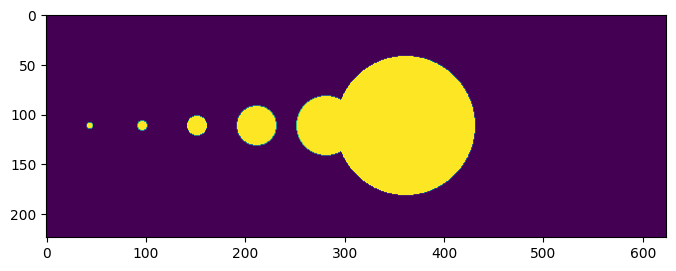

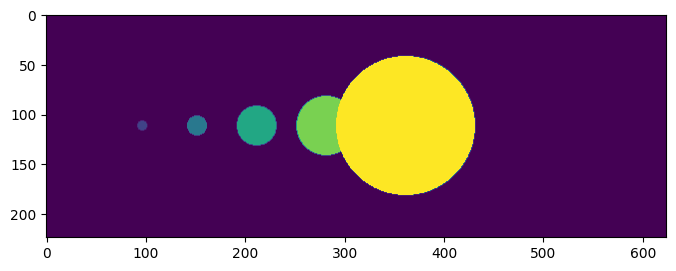

In [28]:

width, height = 624, 224

image = np.zeros([height, width], dtype=np.float32)
truth = np.zeros([height, width], dtype=np.float32)

rs = [3, 5, 10, 20, 30, 70]

x_ = 44

i = 0
for r in rs:
    x, y = x_, 112
    size = [math.ceil(r*2), math.ceil(r*2)]
    size = [224, 224]
    temp=rg.circle(size, r)
    add_small_to_large_2d(image, temp, x, y, mode='replace_non_zero')
    add_small_to_large_2d(truth, i*temp, x, y, mode='replace_non_zero')
    x_ = x_ + 50+r
    i += 1

fig = imshow2d(image)
fig = imshow2d(truth)

## Repeat the objects to make a fake training set

Just repeat a few times to make a trivial training set.  No need to even add blur or noise, we just want to see if a custom model can learn different scales. 

In [29]:
X = []
Y = []
for i in range(10):
    X = X+[image.copy().astype('float32')[..., np.newaxis] for i in range(10)]
    Y = Y+[truth.copy().astype('uint16') for i in range(10)]

len(X)

100

## Make a custom model

In [11]:
import os

model_path = r'./'
model_name = 'custom'
logger = io.logger_setup()
model_custom = models.CellposeModel(gpu=True, model_type=None)#, pretrained_model=os.path.join(model_path,'models',model_name))

creating new log file
2024-10-03 17:00:05,908 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2024-10-03 17:00:05,909 [INFO] 
cellpose version: 	3.0.9 
platform:       	win32 
python version: 	3.10.14 
torch version:  	2.2.2+cu118
2024-10-03 17:00:05,912 [INFO] ** TORCH CUDA version installed and working. **
2024-10-03 17:00:05,913 [INFO] >>>> using GPU
2024-10-03 17:00:06,044 [INFO] >>>> no model weights loaded


## Train our custom model

Note our fake training set was trivial, a set of images each containing single circle ranging from large circles to small.

However I found that in order to learn this very simple data, we need to explicitly set 'rescale' to False when training.

Otherwise the images are rescaled during the training process, and we don't actually learn the different scales. 

In [21]:
from cellpose import train

test=train.train_seg(model_custom.net, X, Y, 
    channels=[0,0], 
    save_path=model_path, 
    n_epochs=600,
    nimg_per_epoch=10,
    min_train_masks=1,
    normalize = False,
    rescale = False,  
    model_name=model_name)

2024-10-03 17:04:58,604 [INFO] computing flows for labels


100%|██████████| 100/100 [00:09<00:00, 10.17it/s]

2024-10-03 17:05:08,463 [INFO] >>> computing diameters



100%|██████████| 100/100 [00:00<00:00, 1671.22it/s]

2024-10-03 17:05:08,528 [INFO] >>> using channels [0, 0]
2024-10-03 17:05:08,579 [INFO] >>> n_epochs=600, n_train=100, n_test=None
2024-10-03 17:05:08,581 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001
2024-10-03 17:05:08,584 [INFO] >>> saving model to models\custom


2024-10-03 17:05:08,812 [INFO] 0, train_loss=0.0601, test_loss=0.0000, LR=0.0000, time 0.23s
2024-10-03 17:05:09,614 [INFO] 5, train_loss=0.0523, test_loss=0.0000, LR=0.0028, time 1.03s
2024-10-03 17:05:10,495 [INFO] 10, train_loss=0.1027, test_loss=0.0000, LR=0.0050, time 1.91s
2024-10-03 17:05:12,156 [INFO] 20, train_loss=0.0837, test_loss=0.0000, LR=0.0050, time 3.57s
2024-10-03 17:05:13,957 [INFO] 30, train_loss=0.0741, test_loss=0.0000, LR=0.0050, time 5.37s
2024-10-03 17:05:15,890 [INFO] 40, train_loss=0.1052, test_loss=0.0000, LR=0.0050, time 7.31s
2024-10-03 17:05:17,630 [INFO] 50, train_loss=0.1083, test_loss=0.0000, LR=0.0050, time 9.05s
2024-10-03 17:05:19,469 [INFO] 60, train_loss=0.1177, test_loss=0.0000, LR=0.0050, time 10.89s
2024-10-03 17:05:21,299 [INFO] 70, train_loss=0.1401, test_loss=0.0000, LR=0.0050, time 12.72s
2024-10-03 17:05:23,104 [INFO] 80, train_loss=0.0889, test_loss=0.0000, LR=0.0050, time 14.52s
2024-10-03 17:05:24,953 [INFO] 90, train_loss=0.0918, test_

In [25]:
labels_custom, c, d = model_custom.eval(image, channels=[0, 0])
truth.sum(), labels_custom.sum()

(89796.0, 25242)

In [27]:
import napari
viewer = napari.Viewer()
viewer.add_labels(labels_custom)
viewer.add_image(image)
viewer.add_image(c[0])

<Image layer 'Image' at 0x1da85039db0>

## Show all the cyto labels and label custom

Note, cyto can only find objects of different sizes by tuning the ```diameter``` param.  Custom can find very different object sizes by default. 

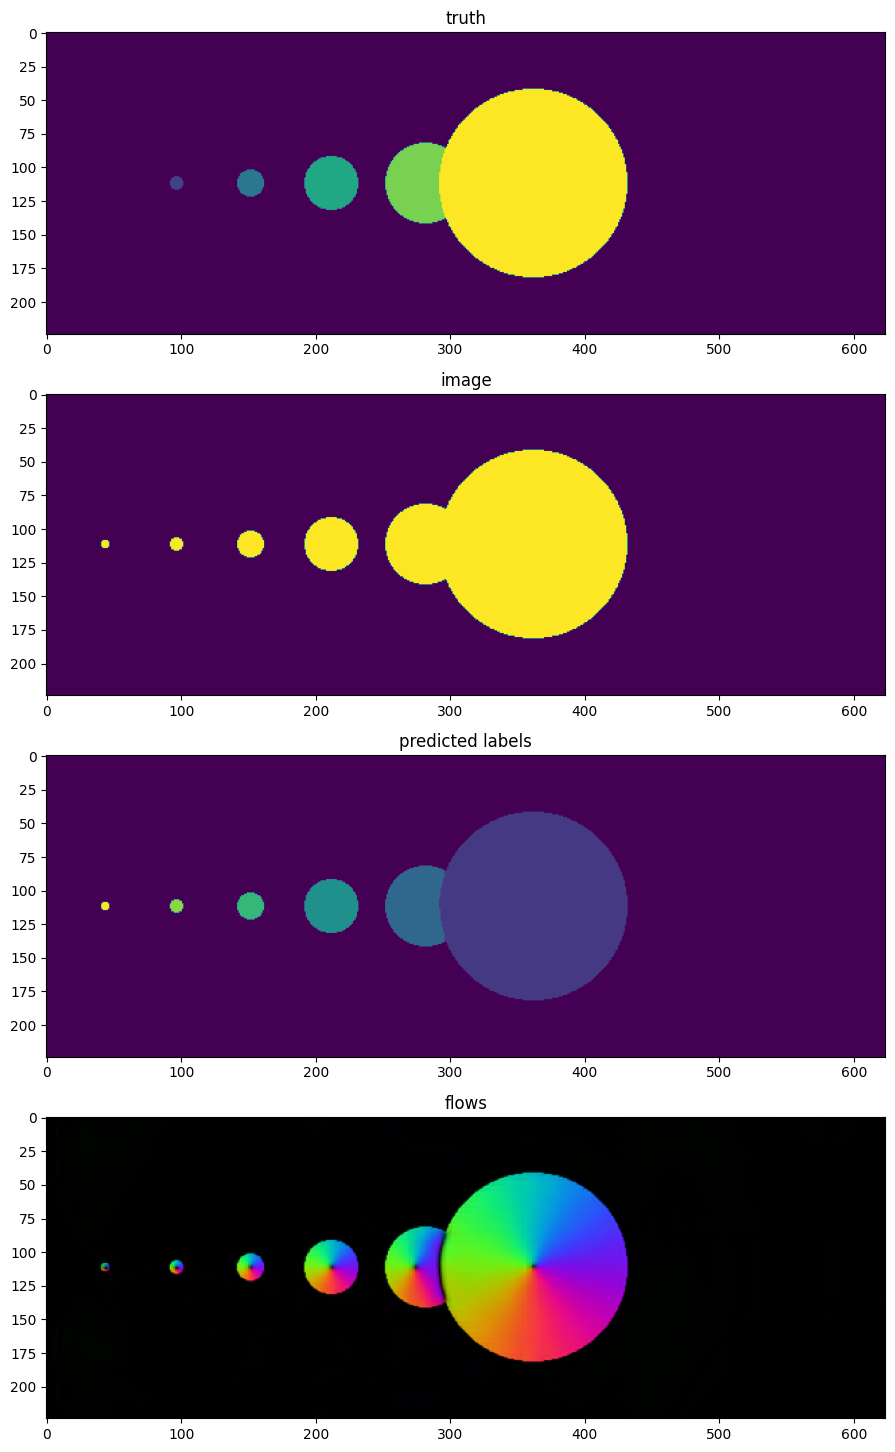

In [30]:
fig = imshow_multi2d([truth, image, labels_custom, c[0]], ['truth', 'image', 'predicted labels', 'flows'],4 ,1, width = 12, height = 18)

In [129]:
print(model_custom.diam_labels)
print(model_cyto2.diam_labels)

30.0
30.0
